<a href="https://colab.research.google.com/github/BasemRizk/Data-Analysis-Visualization/blob/main/OCR_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:

# Set the name of your new directory
IMAGE_DIR='images'

# Set the path where you want to create the new directory
path = "/content/drive/My Drive/" + IMAGE_DIR

# Create the directory
os.makedirs(path, exist_ok=True)

In [4]:
#Place all images in one folder
import shutil
new_dir = '/content/drive/MyDrive/images'
for i in range(0,10):
  current_dir = f'/content/drive/MyDrive/freelance/OCR_Task_Digits_Dataset/dataset/{i}'
  for filename in os.listdir(current_dir):
      if filename.endswith('.png'):
          old_path = os.path.join(current_dir, filename)
          new_path = os.path.join(new_dir, filename)
          shutil.move(old_path, new_path)

In [5]:
#Define the dir_path and img_size
dir_path = '/content/drive/MyDrive/images'
img_size = (240, 240)

In [6]:
#Labeling our images
file_names = os.listdir(dir_path)
label_dict = {}
for file_name in file_names:
    if file_name.endswith('.png'):
        label = file_name.split('_')[0]
        label_dict[file_name] = label

In [7]:
#Resize Images and convert to np.array
images = []
labels = []

for file_name in file_names:
    if file_name.endswith('.png'):
        file_path = os.path.join(dir_path, file_name)
        image = Image.open(file_path)
        image = image.resize(img_size)
        image = np.array(image)
        images.append(image)
        #listing our labels
        labels.append(label_dict[file_name])

In [8]:
label_dict

{'0_103.png': '0',
 '0_1.png': '0',
 '0_101.png': '0',
 '0_100.png': '0',
 '0_10.png': '0',
 '0_102.png': '0',
 '0_11.png': '0',
 '0_104.png': '0',
 '0_105.png': '0',
 '9_85.png': '9',
 '5_2.png': '5',
 '8_61.png': '8',
 '0_81.png': '0',
 '3_22.png': '3',
 '1_17.png': '1',
 '3_18.png': '3',
 '9_86.png': '9',
 '4_40.png': '4',
 '0_34.png': '0',
 '0_85.png': '0',
 '5_54.png': '5',
 '8_17.png': '8',
 '2_33.png': '2',
 '5_86.png': '5',
 '4_74.png': '4',
 '2_49.png': '2',
 '3_71.png': '3',
 '4_60.png': '4',
 '3_67.png': '3',
 '3_29.png': '3',
 '2_61.png': '2',
 '1_64.png': '1',
 '2_42.png': '2',
 '1_86.png': '1',
 '9_13.png': '9',
 '4_9.png': '4',
 '4_46.png': '4',
 '2_37.png': '2',
 '8_21.png': '8',
 '7_48.png': '7',
 '5_21.png': '5',
 '4_47.png': '4',
 '0_35.png': '0',
 '1_88.png': '1',
 '3_47.png': '3',
 '7_23.png': '7',
 '7_18.png': '7',
 '4_12.png': '4',
 '4_103.png': '4',
 '0_31.png': '0',
 '2_10.png': '2',
 '3_14.png': '3',
 '5_48.png': '5',
 '2_69.png': '2',
 '8_36.png': '8',
 '5_45

In [9]:
images[0].shape

(240, 240, 4)

In [10]:
#Convert labels to integers
label=[]
for l in labels:
  label.append(int(l))

In [11]:
#convert labels to np.array
images = np.array(images)
label = np.array(label)

In [12]:
#Plot random images from our dataset
indices = np.random.choice(range(len(images)), replace=False, size=9)
selected_images = images[indices]

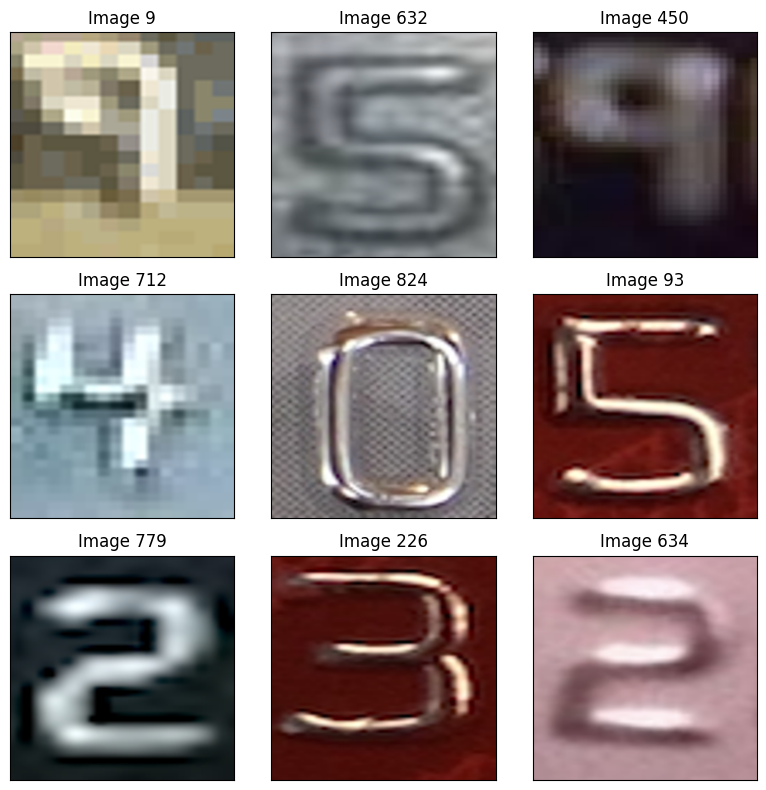

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(selected_images[i])
    ax.set_title(f"Image {indices[i]}")

plt.tight_layout()
plt.show()

In [14]:
for i in indices:
  print('Image',i ,'Label',label[i])

Image 9 Label 9
Image 632 Label 5
Image 450 Label 9
Image 712 Label 4
Image 824 Label 0
Image 93 Label 5
Image 779 Label 2
Image 226 Label 3
Image 634 Label 2


PreProcessing

In [19]:
#convert to grayscale
import cv2

# Load the BGRA image as a NumPy array
Gray_Images=[]
for img in images:
# Convert the BGRA image to grayscale
  bgra_img=img
  gray_img = cv2.cvtColor(bgra_img, cv2.COLOR_BGRA2GRAY)
  Gray_Images.append(gray_img)

In [47]:
#Image Normalization
import numpy as np
from skimage import io, exposure
Normalized_Images=[]
# Load the image as a NumPy array
for img in Gray_Images :

# Normalize the pixel values to the range [0, 1] using min-max scaling
  normalized_img = exposure.rescale_intensity(img, in_range=(0, 255), out_range=(0, 1))
  Normalized_Images.append(normalized_img)


In [86]:
images[0].shape

(240, 240, 4)

In [114]:
import numpy as np
from skimage import io, exposure
Enhanced_Images=[]
# Load the image as a NumPy array
for img in Normalized_Images:
  # Apply contrast stretching to enhance the contrast of the image
  p2, p98 = np.percentile(img, (10, 90))
  enhanced_img = exposure.rescale_intensity(img, in_range=(p2, p98))
  Enhanced_Images.append(enhanced_img)


In [115]:
import numpy as np
Binarized_Images=[]
# Load the image as a NumPy array
for img in Enhanced_Images:
  # Binarize the image using a threshold value of 100
  threshold_value = 0.45
  max_value = 1
  binarized_img = np.where(img < threshold_value, 0, max_value)
  Binarized_Images.append(binarized_img)
# Display the original and binarized images side by side
#stacked_img = np.hstack((img, binarized_img))

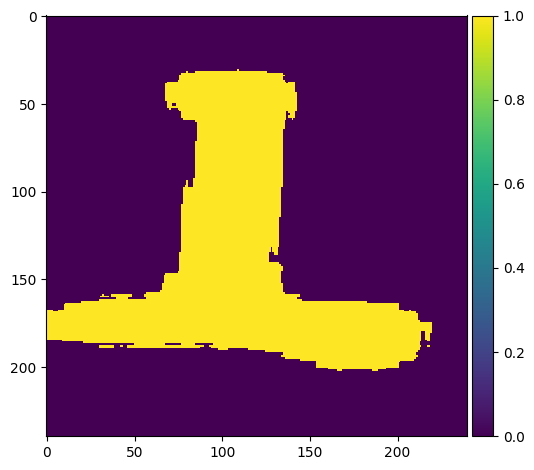

In [125]:
io.imshow(Binarized_Images[807])